C:\Users\liwen\AppData\Local\Temp\ipykernel_24140\999679613.py:73: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  numerator = integrate.simps(sed_int_mJy * response_band, lambda_band)
C:\Users\liwen\AppData\Local\Temp\ipykernel_24140\999679613.py:74: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  denominator = integrate.simps(response_band, lambda_band)


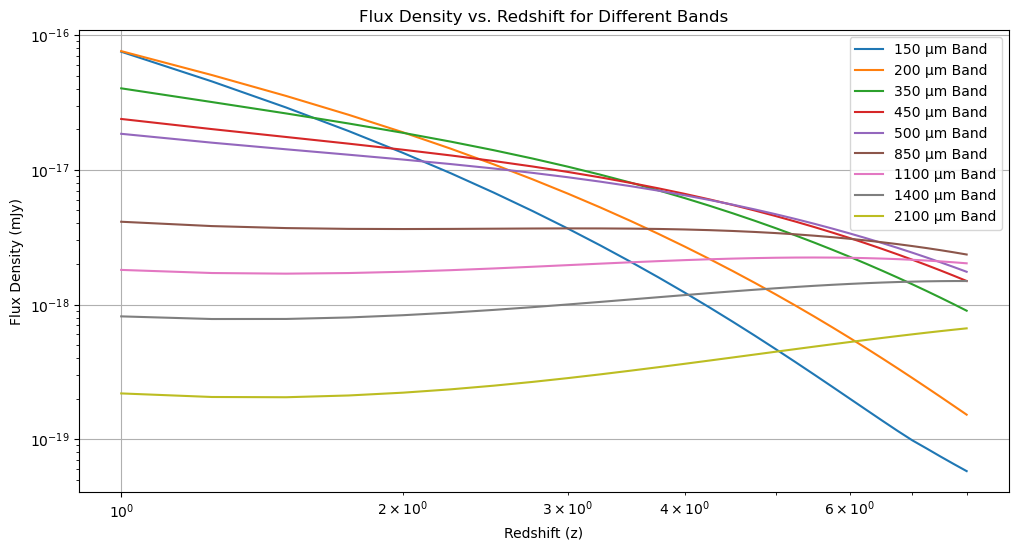

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
from scipy import integrate

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Speed of light in m/s
c = 299792458.0

# Load the SED Data
sed_data = np.loadtxt('aless_average_seds.dat')
wavelength_micron = sed_data[:, 0]  # Wavelength in micrometers
F_nu_mJy = sed_data[:, 1]           # Flux density in mJy

# Convert wavelength to meters
wavelength_m = wavelength_micron * 1e-6  # Convert micrometers to meters

# Create SED array
sed = np.column_stack((wavelength_m, F_nu_mJy))

# Define the Bands using the provided centers in micrometers
band_centers_micron = np.array([150, 200, 350, 450, 500, 850, 1100, 1400, 2100])
band_names = [f'{center} μm' for center in band_centers_micron]

# Assume a bandwidth of 20% of the central wavelength
bandwidths_micron = band_centers_micron * 0.2

# Create band definitions
bands = []
for center, width, name in zip(band_centers_micron, bandwidths_micron, band_names):
    lower_m = (center - width / 2) * 1e-6  # Lower limit in meters
    upper_m = (center + width / 2) * 1e-6   # Upper limit in meters
    lambda_band = np.linspace(lower_m, upper_m, 100)
    response_band = np.ones_like(lambda_band)  # Rectangular bandpass
    band = {'name': name, 'wavelength_m': lambda_band, 'response': response_band}
    bands.append(band)

# Prepare Redshift Array
z_array = np.arange(1, 8.01, 0.25)

# Initialize Results Dictionary
flux_densities = {band['name']: [] for band in bands}

# Main Computation Loop
for z in z_array:
    # Redshift the SED wavelengths
    sed_z_wavelength_m = sed[:, 0] * (1 + z)
    # Adjust flux density (F_nu) for redshift
    sed_z_F_nu_mJy = sed[:, 1] * (1 + z)
    
    # Apply cosmological dimming with (10 pc / D_L)^2
    D_L = cosmo.luminosity_distance(z).to('m').value  # Luminosity distance in meters
    ten_pc_in_meters = 10 * 3.0857e16  # 10 parsecs in meters
    dimming_factor = (ten_pc_in_meters / D_L) ** 2
    observed_F_nu_mJy = sed_z_F_nu_mJy * dimming_factor
    
    # Create redshifted SED
    sed_z = np.column_stack((sed_z_wavelength_m, observed_F_nu_mJy))
    
    # Create interpolation function for the redshifted SED
    sed_z_interp = interp1d(sed_z[:, 0], sed_z[:, 1], bounds_error=False, fill_value=0.0)
    
    # Compute flux density in each band
    for band in bands:
        lambda_band = band['wavelength_m']
        response_band = band['response']
        # Interpolate SED onto band wavelengths
        sed_int_mJy = sed_z_interp(lambda_band)  # in mJy
        # Compute numerator and denominator
        numerator = integrate.simps(sed_int_mJy * response_band, lambda_band)
        denominator = integrate.simps(response_band, lambda_band)
        flux_density_mJy = numerator / denominator
        flux_densities[band['name']].append(flux_density_mJy)

# Plot the Results
plt.figure(figsize=(12, 6))
for band in bands:
    plt.plot(z_array, flux_densities[band['name']], label=f"{band['name']} Band")
plt.xlabel('Redshift (z)')
plt.ylabel('Flux Density (mJy)')
plt.title('Flux Density vs. Redshift for Different Bands')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


In [3]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simps
from astropy.cosmology import FlatLambdaCDM

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

class Spectrum:
    def __init__(self, wavelength, flux):
        self.wavelength = np.array(wavelength)  # in meters
        self.flux = np.array(flux)              # in W/m^2/m
        # Interpolation function
        self._flux_interp = interp1d(
            self.wavelength, self.flux, kind='linear', bounds_error=False, fill_value=0.0
        )

    def flux_at_wavelength(self, wavelength):
        return self._flux_interp(wavelength)  # Returns flux in W/m^2/m

class Filter:
    def __init__(self, wavelength, response):
        self.wavelength = np.array(wavelength)  # in meters
        self.response = np.array(response)
        # Interpolation function
        self._response_interp = interp1d(
            self.wavelength, self.response, kind='linear', bounds_error=False, fill_value=0.0
        )

    def response_at_wavelength(self, wavelength):
        return self._response_interp(wavelength)

class StandardSource(Spectrum):
    def __init__(self, wavelength):
        c = 299792458.0  # Speed of light in m/s
        g_nu = 3631e-26  # AB standard source flux density in W/m^2/Hz
        flux = (c / wavelength**2) * g_nu  # Convert to W/m^2/m
        super().__init__(wavelength, flux)

class KCorrectionCalculator:
    def __init__(self, observed_spectrum, redshift, filter_R, filter_Q, standard_source):
        self.observed_spectrum = observed_spectrum  # Spectrum object
        self.z = redshift
        self.filter_R = filter_R  # Observer-frame filter
        self.filter_Q = filter_Q  # Rest-frame filter
        self.standard_source = standard_source  # StandardSource object

    def compute_k_correction(self):
        c = 299792458.0  # Speed of light in m/s

        # Redshift the SED
        sed_wavelength = self.observed_spectrum.wavelength * (1 + self.z)  # Redshifted wavelengths
        sed_flux = self.observed_spectrum.flux * (1 + self.z)  # Adjusted flux densities

        # Apply cosmological dimming
        D_L = cosmo.luminosity_distance(self.z).to('m').value  # Luminosity distance in meters
        ten_pc_in_meters = 10 * 3.0857e16  # 10 parsecs in meters
        dimming_factor = (ten_pc_in_meters / D_L) ** 2
        sed_flux *= dimming_factor  # Adjust flux densities

        # Create redshifted observed spectrum
        redshifted_spectrum = Spectrum(sed_wavelength, sed_flux)

        # Observer-frame wavelengths and filter response
        lambda_obs = self.filter_R.wavelength  # in meters
        R_lambda = self.filter_R.response

        # Emitted (rest-frame) wavelengths and filter response
        lambda_emit = self.filter_Q.wavelength  # in meters
        Q_lambda = self.filter_Q.response

        # Observed flux density f_lambda at lambda_obs (from redshifted SED)
        f_lambda_obs = redshifted_spectrum.flux_at_wavelength(lambda_obs)  # W/m^2/m

        # Flux density of the standard source g_lambda^R at lambda_obs
        g_lambda_R = self.standard_source.flux_at_wavelength(lambda_obs)  # W/m^2/m

        # Flux density of the standard source g_lambda^Q at lambda_emit
        g_lambda_Q = self.standard_source.flux_at_wavelength(lambda_emit)  # W/m^2/m

        # Observed wavelengths corresponding to emitted wavelengths
        lambda_obs_from_emit =  lambda_emit*(1 + self.z)

        # Observed flux density f_lambda at (1+z)*lambda_emit (from redshifted SED)
        f_lambda_obs_from_emit = redshifted_spectrum.flux_at_wavelength(lambda_obs_from_emit)  # W/m^2/m

        # Numerators and denominators in the equation
        N1 = simps(lambda_obs * f_lambda_obs * R_lambda, lambda_obs)
        N2 = simps(lambda_emit * g_lambda_Q * Q_lambda, lambda_emit)
        D1 = simps(lambda_obs * g_lambda_R * R_lambda, lambda_obs)
        D2 = simps(lambda_emit * f_lambda_obs_from_emit * Q_lambda, lambda_emit)

        # Compute K-correction
        K = -2.5 * np.log10((1 / (1 + self.z)) * (N1 * N2) / (D1 * D2))

        return K



C:\Users\liwen\AppData\Local\Temp\ipykernel_50880\410174620.py:41: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  eff_wavelength = simps(wavelength_m * response, wavelength_m) / simps(response, wavelength_m)
C:\Users\liwen\AppData\Local\Temp\ipykernel_50880\2962186970.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  dimming_factor = (ten_pc_in_meters / D_L) ** 2
C:\Users\liwen\AppData\Local\Temp\ipykernel_50880\2962186970.py:59: RuntimeWarning: invalid value encountered in multiply
  sed_flux *= dimming_factor  # Adjust flux densities
C:\Users\liwen\AppData\Local\Temp\ipykernel_50880\2962186970.py:88: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  N1 = simps(lambda_obs * f_lambda_obs * R_lambda, lambda_obs)
C:\Users\liwen\AppData\Local\Temp\ipykernel_50880\2962186970.py:89: DeprecationWarning:

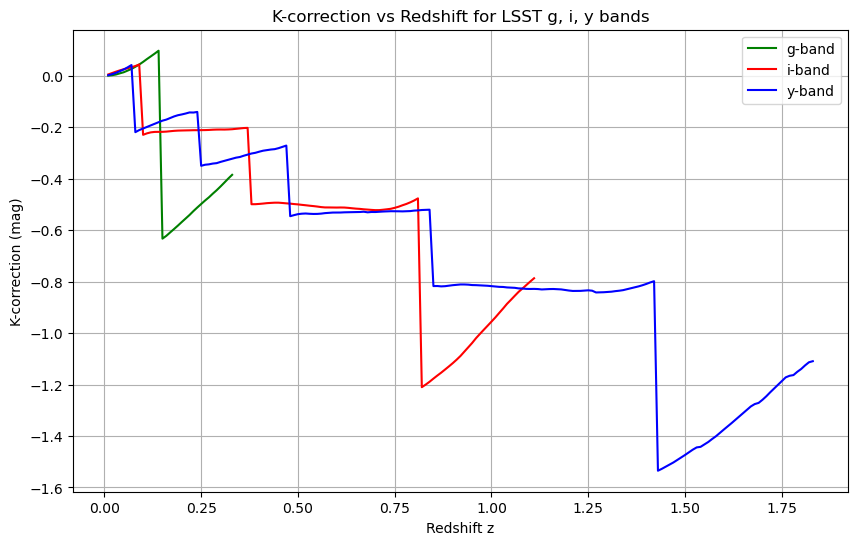

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
from astropy.cosmology import FlatLambdaCDM

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Speed of light in m/s
c = 299792458.0

# Load the SED Data
sed_data = np.loadtxt('aless_average_seds.dat')
wavelength_sed_micron = sed_data[:, 0]  # Wavelength in micrometers
flux_nu_mJy = sed_data[:, 1]            # Flux density in mJy

# Convert wavelength to meters and flux to W/m^2/m
wavelength_sed = wavelength_sed_micron * 1e-6  # Convert micrometers to meters
flux_nu_W_m2_Hz = flux_nu_mJy * 1e-26  # Convert mJy to W/m^2/Hz
flux_lambda_W_m2_m = (flux_nu_W_m2_Hz * c) / (wavelength_sed**2)  # Convert to W/m^2/m

# Create observed spectrum
observed_spectrum = Spectrum(wavelength_sed, flux_lambda_W_m2_m)

# Create standard source (AB)
standard_wavelength = np.linspace(300e-9, 1100e-9, 1000)  # 300 nm to 1100 nm
standard_source = StandardSource(standard_wavelength)

# Load LSST filters
bands = ['u', 'g', 'r', 'i', 'z', 'y']
filters = {}
eff_wavelengths = {}
for band in bands:
    filter_data = np.loadtxt(f'./data/LSST_LSST.{band}_filter.dat')
    wavelength_angstrom = filter_data[:, 0]  # Wavelength in Angstroms
    response = filter_data[:, 1]
    wavelength_m = wavelength_angstrom * 1e-10  # Convert to meters
    filters[band] = Filter(wavelength_m, response)
    # Compute effective wavelength
    eff_wavelength = simps(wavelength_m * response, wavelength_m) / simps(response, wavelength_m)
    eff_wavelengths[band] = eff_wavelength

# Observer-frame bands
observer_bands = ['g', 'i', 'y']

# Redshift array
z_array = np.arange(0, 2.01, 0.01)

# Initialize results
K_corrections = {band: [] for band in observer_bands}
z_valid = {band: [] for band in observer_bands}

# Main computation loop
for z in z_array:
    D_L = cosmo.luminosity_distance(z).to('m').value  # Luminosity distance in meters

    for obs_band in observer_bands:
        # Observer-frame effective wavelength
        lambda_eff_obs = eff_wavelengths[obs_band]
        # Rest-frame wavelength
        lambda_eff_rest = lambda_eff_obs / (1 + z)

        # Find the rest-frame band with closest effective wavelength
        rest_bands = ['u', 'g', 'r', 'i', 'z', 'y']
        rest_lambdas = np.array([eff_wavelengths[band] for band in rest_bands])

        # Calculate differences
        delta_lambda = np.abs(rest_lambdas - lambda_eff_rest)
        min_index = np.argmin(delta_lambda)
        min_band = rest_bands[min_index]

        # Check if mapping is valid
        if lambda_eff_rest < rest_lambdas.min() or lambda_eff_rest > rest_lambdas.max():
            continue  # Stop computing for this band at this redshift
        else:
            filter_R = filters[obs_band]
            filter_Q = filters[min_band]

            # Initialize KCorrectionCalculator
            k_corr_calc = KCorrectionCalculator(
                observed_spectrum=observed_spectrum,
                redshift=z,
                filter_R=filter_R,
                filter_Q=filter_Q,
                standard_source=standard_source
            )

            # Compute K-correction
            K_correction = k_corr_calc.compute_k_correction()

            K_corrections[obs_band].append(K_correction)
            z_valid[obs_band].append(z)

# Plotting the K-correction curves
plt.figure(figsize=(10, 6))
colors = {'g': 'green', 'i': 'red', 'y': 'blue'}
for band in observer_bands:
    plt.plot(z_valid[band], K_corrections[band], label=f'{band}-band', color=colors[band])
plt.xlabel('Redshift z')
plt.ylabel('K-correction (mag)')
plt.title('K-correction vs Redshift for LSST g, i, y bands')
plt.legend()
plt.grid(True)
plt.show()
